# Diabetes Classification

## About dataset
- The Behavioral Risk Factor Surveillance System (BRFSS) is a health-related telephone survey that collects data from U.S. residents on their health-related risk behaviors, chronic health conditions, and use of preventive services
- The dataset has been established in 1984 with 15 states, it now collects data from all 50 states, D.C., and 3 U.S. territories
- Over 400,000 adult interviews are completed each year, making it the largest continuous health survey system in the world
- Factors assessed include tobacco use, healthcare coverage, HIV/AIDS knowledge/prevention, physical activity, and fruit/vegetable consumption
- A record in the data corresponds to a single respondent (each from a single household)
- The description of columns can be found in the linked PDF file

Exploration showed the imbalance of target label. No was the dominant category with over 80% and Yes category populated around 15% of the dataset. The others are ignored and dropped.

#### Features description
| Feature               | Description                                                                  |
|-----------------------|------------------------------------------------------------------------------|
| diabetes              | Subject was told they have diabetes                                          |
| high_blood_pressure   | Subject has high blood pressure                                              |
| high_cholesterol      | Subject has high cholesterol                                                 |
| cholesterol_check     | Subject had cholesterol check within the last five years                     |
| bmi                   | BMI of the subject                                                           |
| smoked_100_cigarettes | Subject has smoked at least 100 cigarettes during their life                 |
| stroke                | Subject experienced stroke during their life                                 |
| coronary_disease      | Subject has/had coronary heart disease or myocardial infarction              |
| exercise              | Subject does regular exercise or physical activity                           |
| consumes_fruit        | Subject consumes fruits at least once a day                                  |
| consumes_vegetables   | Subject consumes vegetables at least once a day                              |
| heavy_alcohol_drinker | Heavy drinkers are defined as adult men having more than 14 drinks per week |
| insurance             | Subject has some kind of health plan (insurance, prepaid plans, ...)         |
| no_doctor_money       | Subject was unable to visit doctor in the past 12 months because of cost     |
| health                | How good is the health of the subject (self rated)                           |
| mental_health         | Number of days in the past month when subject's mental health was not good   |
| physical_health       | Number of days in the past month when subject's physical health was not good |
| climb_difficulty      | Subject has difficulties climbing stairs                                     |
| sex                   | Sex of the subject                                                           |
| age_category          | Age category of the subject                                                  |
| educatation_level     | Highest level of education achieved by the subject                           |
| income                | Income of subject's household                                                |;

Load the dataset. All 5 parts are concatenated

In [108]:
from core import load_dataset

dataset = load_dataset("data")

Do basic preprocessing on columns and categorical values in order to make the dataset more humanly readable.

In [109]:
from core import process_columns, remove_unusable_diabetes_categories

process_columns(dataset)

# 'Unnamed: 0' is a duplicate column of ID
dataset.drop("Unnamed: 0", axis="columns", inplace=True)

# There are some duplicate rows in the dataset
dataset.drop_duplicates(inplace=True)

# ID is no longer needed after dropping duplicates
dataset.drop("ID", axis="columns", inplace=True)

# Remove rows where target label is missing
dataset = dataset[~dataset["diabetes"].isna()]

# Remove pre diabetes and diabetes in pregnancy categories
dataset = remove_unusable_diabetes_categories(dataset)

We need to split the dataset into training and testing.

In [110]:
from sklearn.model_selection import train_test_split

diabetes_X, diabetes_y = dataset.drop(columns="diabetes"), dataset.diabetes

diabetes_train_X, diabetes_test_X, diabetes_train_y, diabetes_test_y = train_test_split(
    diabetes_X, diabetes_y, test_size=0.2, random_state=42
)

### Now we create the random forest model.

The Scikit learn implementation of RF model requires that we first convert the data into numerical format. Otherwise we don't have to do any further preprocessing.

It works by constructing a decision tree during the learning process. At each node, it selects the feature that best splits the dataset. The final model classifies into the category that is the output of the most trees.

In [112]:
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

# We can use ordinal encoding for categorical features, even though there is no ordinal relationship between the categories
categorical_transformer = Pipeline(
    steps=[("encoder", OrdinalEncoder())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, make_column_selector(dtype_include="category")),
    ]
)

# Create the pipeline
random_forest_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            RandomForestClassifier(
                random_state=42,
                class_weight="balanced_subsample",
                max_depth=12,
                max_features="sqrt",
                max_leaf_nodes=50,
                min_samples_leaf=50,
                n_estimators=120,
            ),
        ),
    ]
)

## Grid search for hyperparameter tuning, commented out, because it takes a long time to run
#
# param_grid = {
#     "classifier__class_weight": ["balanced", "balanced_subsample", None],
#     "classifier__max_depth": [12, 15, 20, None],
#     "classifier__max_features": [None, "sqrt", "log2"],
#     "classifier__min_samples_leaf": [3, 3**2, 3**3, 3**4],
#     "classifier__max_leaf_nodes": [25, 50, 100, None],
#     "classifier__min_samples_leaf": [3, 3**2, 3**3, 3**4],
#     "classifier__n_estimators": [40, 80, 120, 160, 200],
# }
#
# clf = GridSearchCV(random_forest_model, param_grid, scoring="recall_macro", n_jobs=-1)
# clf.fit(diabetes_train_X[:3000], diabetes_train_y[:3000])
#
# print(clf.best_params_)
# print(classification_report(diabetes_test_y, clf.predict(diabetes_test_X)))

# Fit the model
random_forest_model.fit(diabetes_train_X, diabetes_train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fff1fea3c50>)])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=12, max_leaf_nodes=50,
                                        min_samples_leaf=50, n_estimators=120,
                                        random_state=42))])

Let's see how our first model performs.

Recall:		0.8185448862649766
Precision:	0.2837963938472653
F1:		0.42146672925188317
Accuracy:	0.6985862679336687


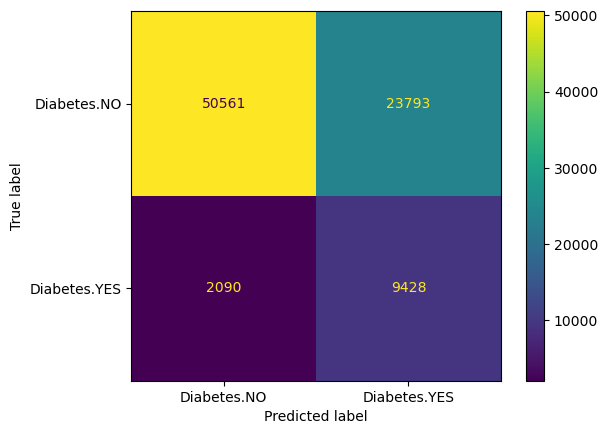

In [113]:
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score, f1_score, accuracy_score


rfm_pred = random_forest_model.predict(diabetes_test_X)

print(f"Recall:\t\t{recall_score(diabetes_test_y, rfm_pred, pos_label='Diabetes.YES')}")
print(
    f"Precision:\t{precision_score(diabetes_test_y, rfm_pred, pos_label='Diabetes.YES')}"
)
print(f"F1:\t\t{f1_score(diabetes_test_y, rfm_pred, pos_label='Diabetes.YES')}")
print(f"Accuracy:\t{accuracy_score(diabetes_test_y, rfm_pred)}")

# Display confusion matrix
cm = confusion_matrix(diabetes_test_y, rfm_pred)
ConfusionMatrixDisplay(cm, display_labels=random_forest_model.classes_).plot()
plt.show()

### And next a perceptron.

This time, we're going to need to preprocess the data via one hot encoder, because we can't work with categorical data. We use simple imputer to get rid of NaN values, and we use standard scaler because the perceptron algorithm is sensitive to big values.

In perceptron algorithm we are trying to find a weight vector that is consistent with plane D (assuming that D is linearly separable). We do this by going through the training examples and adjusting weights based on the outcome on each example. When the example is not corrrectly classified, we turn the hyperplane so that it is closer to being correctly classified. If we went through all of the examples we start again with the first one until the desired outcome (consistent weight vector) is achieved.

In [114]:
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Perceptron
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder


perceptron_column_transformer = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
)

perceptron_model = make_pipeline(
    perceptron_column_transformer,
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    Perceptron()
)

params_grid = {
    "perceptron__class_weight": [None, 'balanced'],
    "perceptron__penalty": [None, 'l2', 'l1', 'elasticnet'],
    "perceptron__alpha": [0.0001, 0.001, 0.01, 0.1],
    "perceptron__eta0": [0.1, 1, 10],
    "perceptron__shuffle": [True, False]
}

clf = GridSearchCV(perceptron_model, params_grid, cv=10, scoring="recall_macro", n_jobs=-1)
# clf.fit(X_train[:2000], y_train[:2000])

# print(clf.best_params_)
# print(classification_report(y_test, clf.predict(X_test), zero_division=0.0))

Based on grid search we choose to create this model.

Recall:		0.8378190658100365
Precision:	0.22570459595368964
F1:		0.35560960330182595
Accuracy:	0.5927310415502143


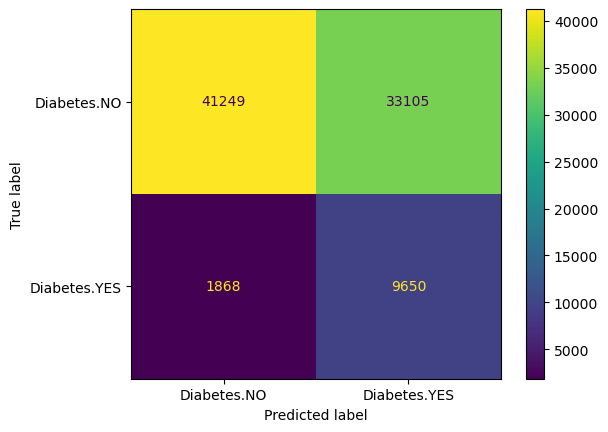

In [115]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)

perceptron_final_model = make_pipeline(
    perceptron_column_transformer,
    SimpleImputer(strategy="mean"),
    StandardScaler(),
    Perceptron(
        alpha=0.0001, class_weight="balanced", eta0=0.1, penalty="l1", shuffle=False
    ),
)

perceptron_final_model.fit(diabetes_train_X[:10000], diabetes_train_y[:10000])

svm_predicted = perceptron_final_model.predict(diabetes_test_X)


print(f"Recall:\t\t{recall_score(diabetes_test_y, svm_predicted, pos_label='Diabetes.YES')}")
print(f"Precision:\t{precision_score(diabetes_test_y, svm_predicted, pos_label='Diabetes.YES')}")
print(f"F1:\t\t{f1_score(diabetes_test_y, svm_predicted, pos_label='Diabetes.YES')}")
print(f"Accuracy:\t{accuracy_score(diabetes_test_y, svm_predicted)}")

# Display confusion matrix
cm = confusion_matrix(diabetes_test_y, svm_predicted)
ConfusionMatrixDisplay(cm, display_labels=perceptron_final_model.classes_).plot()
plt.show()

### Now let's look at the SVM Model

For the preprocessing:
- MinMaxScaling - Scaling the data to range between 0 and 1 is important because SVM is based on computing distances. Without scaling, some feature could dominate if it had larger scale
- OneHotEncoder - SVM requires one-hot encoding to represent categorical variables numerically so that the distances can be computed
- KNNImputer - Scikit-learn's SVM does not work with missing data, hence the need for imputation. KNNImputer performed better than SimpleImputer

SVM works by finding a hyperplane that bests separates the  datapoints (represented as vectors) while maximizing margin - the distance between the hyperplane and the closest datapoint from each class. If the data is not linearly separable, SVM maps the data into higher-dimensional space, where it can be linearly separated.

In [116]:
# # SVM Model

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

svm_column_transformer = make_column_transformer(
    (MinMaxScaler(), make_column_selector(dtype_include=["int64", "float64"])),
    (OneHotEncoder(sparse_output=False), make_column_selector(dtype_include="category")),
    remainder="passthrough"
)


svm_pipeline = make_pipeline(
    svm_column_transformer,
    KNNImputer(n_neighbors=3),
    MinMaxScaler(feature_range=(0, 1)),
    SVC(kernel="poly", C=8, degree=5, class_weight="balanced")
)

In [117]:
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import GridSearchCV

params = [
    {
    # "knnimputer__n_neighbors": [1, 2, 3, 5],
    "svc__kernel": ["poly"],
    "svc__C": [0.5, 1, 2, 4, 8, 16],
    "svc__degree": [1, 2, 3, 4, 5, 6],
    },
    {
    # "knnimputer__n_neighbors": [1, 2, 3, 5],
    "svc__kernel": ["rbf"],
    "svc__C": [0.001, 0.05, 0.5, 1, 2, 4, 8, 16, 20],
    "svc__gamma": ["auto", 0.0001, .0002, 0.00025, 0.0003, 0.0005, 0.001, 0.01, 0.1, 1, 2, 4, 8]
    },
    {
    # "knnimputer__n_neighbors": [1, 2, 3, 5],
    "svc__kernel": ["linear"],
    }
]


recall_diabetes = make_scorer(recall_score, pos_label="Diabetes.YES")
grid_search = GridSearchCV(svm_pipeline, cv=3, param_grid=params, scoring=recall_diabetes, verbose=2, n_jobs=3)
# grid_search.fit(diabetes_train_X, diabetes_train_y)
# grid_search.best_score_
# grid_search.best_params # kernel='rbf'; C=0.05; gamma=0.1; n_neighbors=3

Recall:		0.7980552179197777
Precision:	0.2750366536010293
F1:		0.40908787467455887
Accuracy:	0.6907606670393144


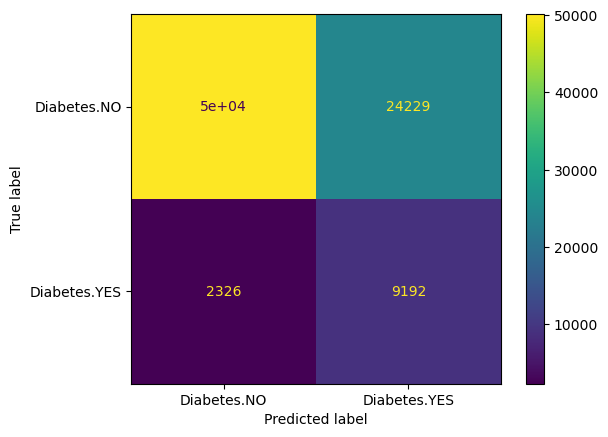

In [118]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
    precision_score,
)

# Final SVM pipeline
svm_pipeline = make_pipeline(
    svm_column_transformer,
    KNNImputer(n_neighbors=3),
    MinMaxScaler(feature_range=(0, 1)),
    SVC(kernel="rbf", C=0.05, gamma=0.1, class_weight="balanced",)
)

svm_pipeline.fit(diabetes_train_X[:10000], diabetes_train_y[:10000])

svm_predicted = svm_pipeline.predict(diabetes_test_X)


print(f"Recall:\t\t{recall_score(diabetes_test_y, svm_predicted, pos_label='Diabetes.YES')}")
print(f"Precision:\t{precision_score(diabetes_test_y, svm_predicted, pos_label='Diabetes.YES')}")
print(f"F1:\t\t{f1_score(diabetes_test_y, svm_predicted, pos_label='Diabetes.YES')}")
print(f"Accuracy:\t{accuracy_score(diabetes_test_y, svm_predicted)}")

# Display confusion matrix
cm = confusion_matrix(diabetes_test_y, svm_predicted)
ConfusionMatrixDisplay(cm, display_labels=svm_pipeline.classes_).plot()
plt.show()

### Interpretation of models

All of our models have succesfully reached respectable level of recall, as we prioritized.
However, the other properties are not so great, unfortunately.
Mainly the precision, our models are way too tragic when it comes to false positives.
It would likely happen way too often that a healthy patient gets diagnosed with diabetes in practical environment.
Accuracy though is also quite good.

### Baseline



In [122]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

baseline = DummyClassifier(strategy="uniform", random_state=0)
baseline.fit(diabetes_train_X, diabetes_train_y)
print(
    classification_report(
        diabetes_test_y, baseline.predict(diabetes_test_X), zero_division=0
    )
)

              precision    recall  f1-score   support

 Diabetes.NO       0.87      0.87      0.87     74354
Diabetes.YES       0.14      0.13      0.14     11518

    accuracy                           0.77     85872
   macro avg       0.50      0.50      0.50     85872
weighted avg       0.77      0.77      0.77     85872

